`Work was done 13.03.2020`

## О чём
В данном ноутбуке приведено моё решение inclass соревнования по машинному обучению, [ссылка](https://www.kaggle.com/c/ozonmasters-ml2-2020-c1)

Цель соревнования - __предсказание отмены заказа в такси__

Данное решение дает скор на паблике ~0.77878 и на прайвате ~0.77532, что примерно равносильно третьему месту по итогам.

Весь ноутбук работает ~22 минуты, для получения финального сабмита, достаточно просто его запустить.

Импортируем все необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import haversine_distances, euclidean_distances
#plt.style.use('dark_background') # т.к. я использую черную тему в каггл кернелах.
%matplotlib inline

Считаем данные

In [3]:
train = pd.read_csv('train_data.csv')
target = pd.read_csv('train_target.csv')
test = pd.read_csv('test_data.csv')
train['target'] = target

Напишем дополнительные функции, которые будут полезны при препроцессинге данных или просто удобны

In [4]:
R = 6371 # радиус Земли, нужен для формулы
# получим координаты в виду tuple для дальнейшего подсчета расстояний

# преобразуем временную колонку в необходимый тип и выделим значимые фичи
def trans_time(df):
    df['due'] = pd.to_datetime(df['due'])
    df['day'] = df['due'].dt.weekday
    df['hour'] = df['due'].dt.hour
    

# label encoding кат. фичей
def cat_code(df):
    df['f'] = df['f_class'].astype('category').cat.codes
    df['s'] = df['s_class'].astype('category').cat.codes
    df['t'] = df['t_class'].astype('category').cat.codes


# расстояния до пяти основных городов и до ближайшего из них
def add_dist_to_city(df):
    msk = [55.753215, 37.622504]
    spb = [59.939095, 30.315868]
    vor = [51.660781, 39.200269]
    nov = [56.326797, 44.006516]
    kaz = [55.796289, 49.108795]
    lat = df.lat.values
    lon = df.lon.values
    coords = np.radians(np.array([lat, lon]).T)
    cities = np.array([msk, spb, vor, nov, kaz])
    cities = np.radians(cities)
    city_names = ['dist_to_msk', 'dist_to_spb', 'dist_to_vor', 'dist_to_nov', 'dist_to_kaz']
    dists = R * haversine_distances(cities, coords)
    for i, name in enumerate(city_names):
        df[name] = dists[i, :]
    df['dist_to_city'] = df[city_names].min(axis=1)
    
    
# расстояния до аэропортов в городах и до ближайшего из них
def add_dist_to_aer(df):
    vnukovo = [55.6058121, 37.2882462]
    domod = [55.4145088, 37.8999786]
    sherem = [55.974247, 37.4058723]
    spb_aer = [59.799770, 30.273027]
    vor_aer = [51.812612, 39.225361]
    nov_aer = [56.219529, 43.791281]
    kaz_aer = [55.608118, 49.298357]
    lat = df.lat.values
    lon = df.lon.values
    coords = np.radians(np.array([lat, lon]).T)
    aeroports = np.array([vnukovo, domod, sherem, spb_aer, vor_aer, nov_aer, kaz_aer])
    aeroports = np.radians(aeroports)
    ae_names = ['dist_to_vnuk',
            'dist_to_domod',
            'dist_to_sherem',
            'dist_to_spb_aer',
            'dist_to_vor_aer',
            'dist_to_nov_aer',
            'dist_to_kaz_aer']
    dists = R * haversine_distances(aeroports, coords)
    for i, name in enumerate(ae_names):
        df[name] = dists[i, :]
    df['dist_to_ae'] = df[ae_names].min(axis=1)
    

# расстояния до вокзалов в городах и до ближайшего из них
def add_dist_to_vok(df):
    bel_vok = [55.776618, 37.581496]
    kaz_vok = [55.773444, 37.655329]
    kiev_vok = [55.743250, 37.567435]
    kursk_vok = [55.756989, 37.661230]
    lenin_vok = [55.776451, 37.655212]
    pavel_vok = [55.729823, 37.640596]
    rizh_vok = [55.792746, 37.632565]
    savel_vok = [55.794355, 37.588260]
    yaros_vok = [55.776472, 37.657727]
    vor_vok1 = [51.640815, 39.258738]
    vor_vok2 = [51.669391, 39.172204]
    vor_vok3 = [51.679751, 39.206066]
    vor_vok4 = [51.640093, 39.258956]
    nov_vok1 = [56.321937, 43.946227]
    kazan_vok1 = [55.788306, 49.100562]
    kazan_vok2 = [55.842224, 49.080763]
    spb_vok1 = [59.929980, 30.362158]
    spb_vok2 = [59.931828, 30.441084]
    spb_vok3 = [59.919901, 30.329181]
    lat = df.lat.values
    lon = df.lon.values
    coords = np.radians(np.array([lat, lon]).T)
    voks = np.array([bel_vok, kaz_vok, kiev_vok, lenin_vok, pavel_vok, rizh_vok, savel_vok, yaros_vok, vor_vok1, vor_vok2,
            vor_vok3, vor_vok4, nov_vok1, kazan_vok1, kazan_vok2, spb_vok1, spb_vok2, spb_vok3])
    voks = np.radians(voks)
    vok_names = ['vok_' + str(i) for i in range(len(voks))]
    dists = R * haversine_distances(voks, coords)
    for i, name in enumerate(vok_names):
        df[name] = dists[i, :]
    df['dist_to_vok'] = df[vok_names].min(axis=1)
    

# Добавим фичи - агрегации
def add_agg_features(df):
    df['gr_lat'] = df.groupby('lat')['lat'].transform('count')
    df['gr_lon'] = df.groupby('lon')['lon'].transform('count')
    df['gr_lat_lon'] = df.groupby(['lat', 'lon'])['lat'].transform('count')
    df['gr_day'] = df.groupby('day')['day'].transform('count')
    df['gr_hour'] = df.groupby('hour')['hour'].transform('count')
    df['gr_day_hour'] = df.groupby(['day', 'hour'])['hour'].transform('count')
    df['gr_hour_lat'] = df.groupby(['hour', 'lat'])['lat'].transform('count')
    df['gr_day_lat'] = df.groupby(['day', 'lat'])['lat'].transform('count')
    df['gr_hour_lon'] = df.groupby(['hour', 'lon'])['lon'].transform('count')
    df['gr_day_lon'] = df.groupby(['day', 'lon'])['lon'].transform('count')
    df['gr_lat_lon_hour'] = df.groupby(['lat', 'lon', 'hour'])['lat'].transform('count')
    df['gr_lat_lon_day'] = df.groupby(['lat', 'lon', 'day'])['lat'].transform('count')
    df['gr_lat_lon_hour_day'] = df.groupby(['lat', 'lon', 'hour', 'day'])['lat'].transform('count')
    

# Добавим фичи на основе ближайших соседей
def add_nn_features(df):
    dists = []
    nn = []
    lat = df.lat.values
    lon = df.lon.values
    radius = df.dist.values
    coords = np.radians(np.array([lat, lon]).T)
    nns = np.array([lat, lon, radius]).T
    n = df.shape[0]
    for i in range(n):
        up = max(i-600, 0)
        down = min(n, i+600)
        coord = coords[i].reshape((1, 2))
        x = nns[i].reshape((1, 3))
        sls = np.r_[up:i, i+1:down]
        dists.append(np.min(haversine_distances(coord, coords[sls])))
        nn.append(np.min(euclidean_distances(x, nns[sls])))
        
    df['dist_to_closest_point'] = dists # расстояние до ближайшей точки в пределах где-то пяти минут
    df['nn'] = nn # ближайший сосед, но с учетом фичи "дистанция"
    


# сделаем фичу - предполагаемую стоимость поездки, как линейная комбинации класса автомобиля и расстояния
# (spoiler - useless)
def create_price(df):
    econom = np.where((df['f_class'] == 'econom') | (df['f_class'].isna()), 1, 0)
    business = np.where(df['f_class'] == 'business', 2, 0)
    vip = np.where(df['f_class'] == 'vip', 3, 0)
    mix = econom + business + vip
    df['price'] = np.where(df['dist'] <=0, df[df['dist'] > 0]['dist'].mean(), df['dist']) * mix
    

# Обработка погодных данных
def add_weather(df):
    msk_weather = pd.read_json('../input/ozonmasters-ml2-2020-c1/weather_data/weather_data/group-city-moscow.jsonl', lines=True)
    spb_weather = pd.read_json('../input/ozonmasters-ml2-2020-c1/group-city-spb-fixed.jsonl', lines=True)
    vor_weather = pd.read_json('../input/ozonmasters-ml2-2020-c1/weather_data/weather_data/group-city-voronezh.jsonl', lines=True)
    nov_weather = pd.read_json('../input/ozonmasters-ml2-2020-c1/weather_data/weather_data/group-city-nnovgorod.jsonl', lines=True)
    kaz_weather = pd.read_json('../input/ozonmasters-ml2-2020-c1/weather_data/weather_data/group-city-kazan.jsonl', lines=True)
    city_names = ['dist_to_msk', 'dist_to_spb', 'dist_to_vor', 'dist_to_nov', 'dist_to_kaz']
    df['cluster'] = df[city_names].idxmin(axis=1)
    df['time'] = df.due.dt.floor('H')
    msk_weather.time = pd.to_datetime(msk_weather.time)
    msk_weather['cluster'] = 'dist_to_msk'
    spb_weather.time = pd.to_datetime(spb_weather.time)
    spb_weather['cluster'] = 'dist_to_spb'
    vor_weather.time = pd.to_datetime(vor_weather.time)
    vor_weather['cluster'] = 'dist_to_vor'
    nov_weather.time = pd.to_datetime(nov_weather.time)
    nov_weather['cluster'] = 'dist_to_nov'
    kaz_weather.time = pd.to_datetime(kaz_weather.time)
    kaz_weather['cluster'] = 'dist_to_kaz'
    result = [msk_weather, spb_weather, vor_weather, nov_weather, kaz_weather]
    result = pd.concat(result)
    df = pd.merge(df, result, on=['cluster', 'time'], how='left')
    df['gr_temperature'] = df.groupby('temperature')['temperature'].transform('count')
    df['gr_wind_speed'] = df.groupby('wind_speed')['wind_speed'].transform('count')
    df['summary_cat'] = df['summary'].astype('category').cat.codes
    return df
    
    
    
# для отрисовки важности фичей после обучения lgb
def feat_imp(clf):
    feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
    feat_importances.nlargest(20).plot(kind='barh')
    plt.show()
    
    
# чтобы удобно делать сабмит через одно слово :)
def create_submit(preds, name):
    submit = pd.DataFrame({'index':range(0, preds.shape[0]), 'target':preds})
    submit.to_csv(name, index=False)

Отсортируем треин и тест по дате и объединим, чтобы сразу модернизировать все данные

In [5]:
train.sort_values(by='due', inplace=True)
test.sort_values(by='due', inplace=True)
train_test = train.sort_values(by='due').append(test.sort_values(by='due'), sort=False)

Основной препроцесс

In [6]:
%%time
trans_time(train_test)
cat_code(train_test)
add_dist_to_city(train_test)
#train_test = add_weather(train_test) # без погоды
add_dist_to_aer(train_test)
add_dist_to_vok(train_test)
add_agg_features(train_test)
add_nn_features(train_test)

Wall time: 13min 33s


Проверим, что всё как и ожидалось

In [7]:
train_test.head()

,dist,due,f_class,lat,lon,s_class,t_class,target,day,hour,...,gr_day_hour,gr_hour_lat,gr_day_lat,gr_hour_lon,gr_day_lon,gr_lat_lon_hour,gr_lat_lon_day,gr_lat_lon_hour_day,dist_to_closest_point,nn
823150,17990.125431,2014-01-01 00:09:32,econom,55.750130,37.823242,NaN,NaN,1.0,2,0,...,4490,3,5,2,1,2,1,1,0.000052,29.395668
685195,2322.180999,2014-01-01 00:10:00,econom,55.711488,37.884183,NaN,NaN,0.0,2,0,...,4490,2,11,2,11,2,11,2,0.000000,17.794904
996389,14608.577392,2014-01-01 00:10:00,econom,55.633404,37.797595,NaN,NaN,0.0,2,0,...,4490,1,1,1,1,1,1,1,0.000042,43.140719
497811,20055.569096,2014-01-01 00:10:00,econom,55.780380,37.645240,NaN,NaN,0.0,2,0,...,4490,4,14,4,3,4,3,2,0.000000,55.226096
812346,20585.444093,2014-01-01 00:10:00,econom,55.675676,37.500387,NaN,NaN,1.0,2,0,...,4490,1,1,1,1,1,1,1,0.000008,26.066450


In [8]:
print(train_test.columns)

Index(['dist', 'due', 'f_class', 'lat', 'lon', 's_class', 't_class', 'target',
       'day', 'hour', 'f', 's', 't', 'dist_to_msk', 'dist_to_spb',
       'dist_to_vor', 'dist_to_nov', 'dist_to_kaz', 'dist_to_city',
       'dist_to_vnuk', 'dist_to_domod', 'dist_to_sherem', 'dist_to_spb_aer',
       'dist_to_vor_aer', 'dist_to_nov_aer', 'dist_to_kaz_aer', 'dist_to_ae',
       'vok_0', 'vok_1', 'vok_2', 'vok_3', 'vok_4', 'vok_5', 'vok_6', 'vok_7',
       'vok_8', 'vok_9', 'vok_10', 'vok_11', 'vok_12', 'vok_13', 'vok_14',
       'vok_15', 'vok_16', 'vok_17', 'dist_to_vok', 'gr_lat', 'gr_lon',
       'gr_lat_lon', 'gr_day', 'gr_hour', 'gr_day_hour', 'gr_hour_lat',
       'gr_day_lat', 'gr_hour_lon', 'gr_day_lon', 'gr_lat_lon_hour',
       'gr_lat_lon_day', 'gr_lat_lon_hour_day', 'dist_to_closest_point', 'nn'],
      dtype='object')


Обратно разделим трейн и тест + проверим, что правильно по размерам всё

In [9]:
train_size = train.shape[0]
train = train_test.iloc[:train_size]
test = train_test.iloc[train_size:]
test.sort_index(inplace=True)
assert(train.shape[0] + test.shape[0] == train_test.shape[0])

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


local validation

In [10]:
size = int(0.7 * train_size)
features = ['dist', 'lat', 'lon', 'day', 'hour', 'f', 's', 't', 'dist_to_city', 'dist_to_ae', 'dist_to_vok',
           'gr_lat', 'gr_lon',
           'gr_lat_lon', 'gr_day', 'gr_hour', 'gr_day_hour', 'gr_hour_lat',
           'gr_day_lat', 'gr_hour_lon', 'gr_day_lon', 'gr_lat_lon_hour',
           'gr_lat_lon_day', 'gr_lat_lon_hour_day', 'dist_to_closest_point', 'nn']
X, y = train[features], train['target'].astype(int)
X_train, X_test = X.iloc[:size], X.iloc[size:]
y_train, y_test = y.iloc[:size], y.iloc[size:]

In [11]:
clf = LGBMClassifier(n_estimators=5000, learning_rate=0.02, num_leaves=111, n_jobs=-1, objective='binary')
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='auc', verbose=25, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[25]	training's auc: 0.757899	training's binary_logloss: 0.363607	valid_1's auc: 0.772178	valid_1's binary_logloss: 0.373766
[50]	training's auc: 0.761597	training's binary_logloss: 0.349121	valid_1's auc: 0.774605	valid_1's binary_logloss: 0.357272
[75]	training's auc: 0.764166	training's binary_logloss: 0.342859	valid_1's auc: 0.776108	valid_1's binary_logloss: 0.350402
[100]	training's auc: 0.766601	training's binary_logloss: 0.3397	valid_1's auc: 0.777452	valid_1's binary_logloss: 0.347158
[125]	training's auc: 0.768839	training's binary_logloss: 0.337826	valid_1's auc: 0.778246	valid_1's binary_logloss: 0.345564
[150]	training's auc: 0.771019	training's binary_logloss: 0.336494	valid_1's auc: 0.778809	valid_1's binary_logloss: 0.344687
[175]	training's auc: 0.773118	training's binary_logloss: 0.335426	valid_1's auc: 0.779269	valid_1's binary_logloss: 0.344091
[200]	training's auc: 0.775053	training's binary_logloss: 0.3

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.02, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=5000, n_jobs=-1, num_leaves=111, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

final submit

In [12]:
clf = LGBMClassifier(n_estimators=800, learning_rate=0.02, num_leaves=111, n_jobs=-1, objective='binary')
clf.fit(X, y)
preds = clf.predict_proba(test[features])[:, 1]
create_submit(preds, 'final_submission.csv')

feature importance

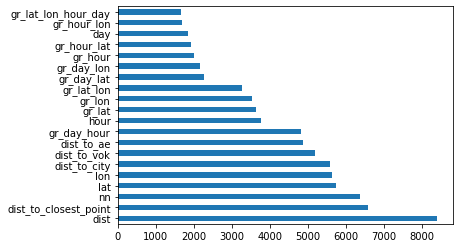

In [13]:
feat_imp(clf)

Ещё немного поработал с оптимизатором лайтгбм - оптуной, работает довольно долго, но неплохо, тем не менее ручной подбор параметров показался мне более оптимальным (по крайней мере в этой задаче).

In [ ]:
# import optuna.integration.lightgbm as lgb

# dtrain = lgb.Dataset(X_train, label=y_train)
# dval = lgb.Dataset(X_test, label=y_test)

# params = {
#         'objective': 'binary',
#         'metric': 'auc',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#     }

# best_params, tuning_history = dict(), list()

# model = lgb.train(params,
#                   dtrain,
#                   valid_sets=[dtrain, dval],
#                   best_params=best_params,
#                   tuning_history=tuning_history,
#                   verbose_eval=100,
#                   early_stopping_rounds=100,
#                   )

# prediction = model.predict(X_test, num_iteration=model.best_iteration)
# accuracy = roc_auc_score(y_test, prediction)

# print('Number of finished trials: {}'.format(len(tuning_history)))
# print('Best params:', best_params)
# print('  Accuracy = {}'.format(accuracy))
# print('  Params: ')
# for key, value in best_params.items():
#     print('    {}: {}'.format(key, value))

### Выводы, мысли, чему научился, что попробовал...

Итак, это моё первое соревнование. На него я в сумме потратил около 50-60 часов ~(да много, да тупо, но я был увлечен)~. За это время я смог разобраться во многих вещах (наверное рутинных по большому счету) и попробовать некоторые штуки. Во-первых, я попробовал визуализацию именно координат точек на карте, что позволило обнаружить некоторые аномалии и вообще сделать выводы по поводу расположения сэмплов (хотя в итоге обнаружение аномалий ничего не дало особо). Во-вторых, разобрался с lightgbm, как использовать, тюнить, какие есть оптимизаторы и чем они отличаются, сколько времени уходит на обучение, от чего оно зависит и т. д. В-третьих, понял, насколько суперполезен (непростой) навык организации работы: как правильно записывать всё, что делал и иметь возможность воспроизвести это. Этому ещё учиться и учиться...Ещё полезно стараться обобщаться всю обработку данных (делать функции) и запихивать в единый пайплайн её. + полезно прикидывать время сколько будет считаться та или иная фича и стараться оптимизировать код (как пример, код, который я написал для подсчета фичи с расстоянием изначально был очень тупой и работал много часов, а под конец соревнования я оптимизировал его и он работает пять минут). Как-то так.